### Stanford Paper on LSTM Neural Networks for stock prices volatility prediction

http://cs230.stanford.edu/projects_fall_2019/reports/26254244.pdf

### Tutorial for building an LSTM neural network for time-series prediction

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

### Importing the required libraries

In [85]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers

# Datetime

import datetime

# Scikit-Learn

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# GARCH model

from arch import arch_model

# Keras

from keras.models import Model
from keras.layers import *
from tensorflow.keras.utils import plot_model

# Tensorflow

import tensorflow as tf

### Reading the csv file with the financial data

In [87]:
df = pd.read_csv(r'stock_data/stock_2116_data.csv')
# 只保留需要的列
df = df[['日期_Date', '开盘价_Oppr', '收盘价_Clpr', '最高价_Hipr', '最低价_Lopr', '成交量_Trdvol']]

# 重命名列名
df = df.rename(columns={
    '日期_Date': 'Date', 
    '开盘价_Oppr': 'Open',
    '收盘价_Clpr': 'Close',
    '最高价_Hipr': 'High',
    '最低价_Lopr': 'Low',
    '成交量_Trdvol': 'Volume'
})
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
print (df.head())
print (df.shape)

             Open  Close   High    Low     Volume
Date                                             
2007-02-16  18.70  19.15  19.35  17.80  8036918.0
2007-02-26  20.00  20.30  20.49  19.40  4010746.0
2007-02-27  20.30  18.70  20.90  18.50  4099589.0
2007-02-28  18.78  20.57  20.57  18.78  3316669.0
2007-03-01  20.58  21.08  21.88  19.88  2630233.0
(3166, 5)


As we see here, we have 254 columns, corresponding to the 254 business days for which we have financial data and 10 columns, which are the 10 financial indicators we have.

# Data Cleaning

In [90]:
# df = df.rename(columns={
    
#     df.columns[0]: 'Date',
#     df.columns[1]:'Open',
#     df.columns[2]: 'Close',
#     df.columns[3]:'High',
#     df.columns[4]:'Low',
#     df.columns[5]: 'Volume',
#     df.columns[6]: 'RSI14',
#     df.columns[7]:'SMA14',
#     df.columns[8]: 'EMA14',
#     df.columns[9]:'MACD_sl',
#     df.columns[10]:'MACD_h'

# })

# print (df.head())

### Converting the Date column into a Date

In [92]:
# df['Date'] =  pd.to_datetime(df['Date'], format='%Y%m%d')

# Feature Engineering

## Logarithmic Features

### Log Returns

In [96]:
df['Log_Returns'] = np.log(df.Close) - np.log(df.Close.shift(1))

print(df.head())
print(df.tail())

             Open  Close   High    Low     Volume  Log_Returns
Date                                                          
2007-02-16  18.70  19.15  19.35  17.80  8036918.0          NaN
2007-02-26  20.00  20.30  20.49  19.40  4010746.0     0.058318
2007-02-27  20.30  18.70  20.90  18.50  4099589.0    -0.082097
2007-02-28  18.78  20.57  20.57  18.78  3316669.0     0.095310
2007-03-01  20.58  21.08  21.88  19.88  2630233.0     0.024491
            Open  Close  High   Low     Volume  Log_Returns
Date                                                       
2020-06-22  7.23   7.14  7.24  7.13  1632382.0    -0.013908
2020-06-23  7.14   7.10  7.18  7.09   880430.0    -0.005618
2020-06-24  7.13   7.04  7.13  7.00  1183500.0    -0.008487
2020-06-29  7.01   6.94  7.05  6.92   824832.0    -0.014306
2020-06-30  7.18   6.99  7.18  6.94   927846.0     0.007179


### Log Trading Range

In [98]:
df['Log_Trading_Range'] = np.log(df.High) - np.log(df.Low)

print(df.head())

             Open  Close   High    Low     Volume  Log_Returns  \
Date                                                             
2007-02-16  18.70  19.15  19.35  17.80  8036918.0          NaN   
2007-02-26  20.00  20.30  20.49  19.40  4010746.0     0.058318   
2007-02-27  20.30  18.70  20.90  18.50  4099589.0    -0.082097   
2007-02-28  18.78  20.57  20.57  18.78  3316669.0     0.095310   
2007-03-01  20.58  21.08  21.88  19.88  2630233.0     0.024491   

            Log_Trading_Range  
Date                           
2007-02-16           0.083494  
2007-02-26           0.054664  
2007-02-27           0.121978  
2007-02-28           0.091041  
2007-03-01           0.095859  


### Log Volume Change

In [100]:
df['Log_Volume_Change'] = np.log(df.Volume) - np.log(df.Volume.shift(1))

print(df.head())

             Open  Close   High    Low     Volume  Log_Returns  \
Date                                                             
2007-02-16  18.70  19.15  19.35  17.80  8036918.0          NaN   
2007-02-26  20.00  20.30  20.49  19.40  4010746.0     0.058318   
2007-02-27  20.30  18.70  20.90  18.50  4099589.0    -0.082097   
2007-02-28  18.78  20.57  20.57  18.78  3316669.0     0.095310   
2007-03-01  20.58  21.08  21.88  19.88  2630233.0     0.024491   

            Log_Trading_Range  Log_Volume_Change  
Date                                              
2007-02-16           0.083494                NaN  
2007-02-26           0.054664          -0.695068  
2007-02-27           0.121978           0.021909  
2007-02-28           0.091041          -0.211926  
2007-03-01           0.095859          -0.231889  


## Volatility

### Previous 10-day Volatility

In [103]:
df['Previous_10_Day_Volatility'] = df['Log_Returns'].rolling(window = 10).std()

print(df.tail())

            Open  Close  High   Low     Volume  Log_Returns  \
Date                                                          
2020-06-22  7.23   7.14  7.24  7.13  1632382.0    -0.013908   
2020-06-23  7.14   7.10  7.18  7.09   880430.0    -0.005618   
2020-06-24  7.13   7.04  7.13  7.00  1183500.0    -0.008487   
2020-06-29  7.01   6.94  7.05  6.92   824832.0    -0.014306   
2020-06-30  7.18   6.99  7.18  6.94   927846.0     0.007179   

            Log_Trading_Range  Log_Volume_Change  Previous_10_Day_Volatility  
Date                                                                          
2020-06-22           0.015310           0.546061                    0.008506  
2020-06-23           0.012614          -0.617385                    0.008391  
2020-06-24           0.018401           0.295821                    0.006718  
2020-06-29           0.018612          -0.361052                    0.007377  
2020-06-30           0.033998           0.117686                    0.008066  


### Previous 30-day Volatility

In [105]:
df['Previous_30_Day_Volatility'] = df['Log_Returns'].rolling(window = 30).std()

print(df.head())

             Open  Close   High    Low     Volume  Log_Returns  \
Date                                                             
2007-02-16  18.70  19.15  19.35  17.80  8036918.0          NaN   
2007-02-26  20.00  20.30  20.49  19.40  4010746.0     0.058318   
2007-02-27  20.30  18.70  20.90  18.50  4099589.0    -0.082097   
2007-02-28  18.78  20.57  20.57  18.78  3316669.0     0.095310   
2007-03-01  20.58  21.08  21.88  19.88  2630233.0     0.024491   

            Log_Trading_Range  Log_Volume_Change  Previous_10_Day_Volatility  \
Date                                                                           
2007-02-16           0.083494                NaN                         NaN   
2007-02-26           0.054664          -0.695068                         NaN   
2007-02-27           0.121978           0.021909                         NaN   
2007-02-28           0.091041          -0.211926                         NaN   
2007-03-01           0.095859          -0.231889         

### Next 10-days volatility

In [107]:
df['Next_10_Days_Volatility'] = df['Log_Returns'].iloc[::-1].rolling(window = 10).std().iloc[::-1]

print(df.head())

             Open  Close   High    Low     Volume  Log_Returns  \
Date                                                             
2007-02-16  18.70  19.15  19.35  17.80  8036918.0          NaN   
2007-02-26  20.00  20.30  20.49  19.40  4010746.0     0.058318   
2007-02-27  20.30  18.70  20.90  18.50  4099589.0    -0.082097   
2007-02-28  18.78  20.57  20.57  18.78  3316669.0     0.095310   
2007-03-01  20.58  21.08  21.88  19.88  2630233.0     0.024491   

            Log_Trading_Range  Log_Volume_Change  Previous_10_Day_Volatility  \
Date                                                                           
2007-02-16           0.083494                NaN                         NaN   
2007-02-26           0.054664          -0.695068                         NaN   
2007-02-27           0.121978           0.021909                         NaN   
2007-02-28           0.091041          -0.211926                         NaN   
2007-03-01           0.095859          -0.231889         

In [108]:
df.dropna(inplace = True)
print(df.head())

             Open  Close   High    Low     Volume  Log_Returns  \
Date                                                             
2007-04-06  25.70  25.71  26.25  25.30   853602.0    -0.007363   
2007-04-09  25.30  25.08  25.71  24.66  1663834.0    -0.024809   
2007-04-10  25.09  24.97  25.36  24.40  1134242.0    -0.004396   
2007-04-11  24.90  25.45  25.60  24.79  1469525.0     0.019041   
2007-04-12  25.56  25.09  25.56  24.90  1464243.0    -0.014246   

            Log_Trading_Range  Log_Volume_Change  Previous_10_Day_Volatility  \
Date                                                                           
2007-04-06           0.036862          -0.611581                    0.020242   
2007-04-09           0.041698           0.667415                    0.020486   
2007-04-10           0.038590          -0.383160                    0.019174   
2007-04-11           0.032152           0.258975                    0.017980   
2007-04-12           0.026161          -0.003601         

In [109]:
df.to_csv('output.csv')

## GARCH 

In [111]:
## Garch predictions for the entire dataset of SPX

### Building a new dataframe for splitting the dataframe in test and training data

In [113]:

X = df[df.first_valid_index():df.last_valid_index()- datetime.timedelta(1500)]

print (X.tail())

             Open  Close   High    Low     Volume  Log_Returns  \
Date                                                             
2016-04-29  13.19  13.10  13.19  13.01  1084976.0    -0.001526   
2016-05-03  13.11  13.58  13.68  13.00  3267163.0     0.035986   
2016-05-04  13.70  13.77  13.91  13.42  3264742.0     0.013894   
2016-05-05  13.70  13.77  13.83  13.56  1994351.0     0.000000   
2016-05-06  13.86  13.03  13.88  12.98  4339162.0    -0.055238   

            Log_Trading_Range  Log_Volume_Change  Previous_10_Day_Volatility  \
Date                                                                           
2016-04-29           0.013741          -0.391492                    0.024546   
2016-05-03           0.050986           1.102364                    0.028316   
2016-05-04           0.035862          -0.000741                    0.028900   
2016-05-05           0.019716          -0.492862                    0.017416   
2016-05-06           0.067039           0.777363         

### Building a GARCH model

In [115]:
GARCH_model = arch_model(X['Log_Returns'], vol='Garch', p=1, q=1, rescale=False)

model_fit = GARCH_model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4116.24
Distribution:                  Normal   AIC:                          -8224.48
Method:            Maximum Likelihood   BIC:                          -8201.83
                                        No. Observations:                 2127
Date:                Thu, Nov 21 2024   Df Residuals:                     2126
Time:                        18:45:26   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.8021e-04  7.353e-04     -0.381      0.703 [-1.721e-03,1.161e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.5104e-04  6.522e-05      2.316  2.057e-02 [2.321e-05,2.789e-04]
alpha[1]       0.0551  3.536e-02      1.559      0.119  [-1.418e-02,  0.124]
beta[1]        0.8310  4.321e-02     19.230  2.066e-82     [  0.746,  0.916]
============================================================================

Covariance estimator: robust
"""

### Making rolling predictions using the GARCH Model

In [117]:
forecast_rolling = model_fit.forecast(horizon=len(X) - 50)

GARCH_rolling_predictions = pd.DataFrame(
    forecast_rolling.variance.iloc[:, 0],  # 一步预测
    index=X.index[50:],
    columns=['GARCH_rolling_predictions']
)

print(GARCH_rolling_predictions.head())

           GARCH_rolling_predictions
Date                                
2007-06-25                       NaN
2007-06-26                       NaN
2007-06-27                       NaN
2007-06-28                       NaN
2007-06-29                       NaN


### Making forward-looking predictions using the GARCH Model

In [119]:
forecast_forward = model_fit.forecast(horizon=1500)

GARCH_forward_looking_predictions = pd.DataFrame(
    forecast_forward.variance,
    index=df.index[-1500:],
    columns=['GARCH_forward_looking_predictions']
)

print(GARCH_forward_looking_predictions.head())

            GARCH_forward_looking_predictions
Date                                         
2014-01-14                                NaN
2014-01-15                                NaN
2014-01-16                                NaN
2014-01-17                                NaN
2014-01-20                                NaN


### Renaming one of the columns of the GARCH Model Dataframe

In [121]:
GARCH_rolling_predictions.rename(columns={'Series':'GARCH_rolling_predictions'}, inplace =True)

GARCH_forward_looking_predictions.rename(columns={'Log_Returns':'GARCH_forward_looking_predictions'}, inplace =True)

### Adding the new feature to the current dataframe

In [123]:
df = pd.concat([df, GARCH_rolling_predictions], axis=1)
df = pd.concat([df, GARCH_forward_looking_predictions], axis=1)

### Replacing Nan values with 0s for the GARCH Predictions columns

Rational for this from Keras's creator:

https://stackoverflow.com/questions/52570199/multivariate-lstm-with-missing-values

In [126]:
print(df.head())

df['GARCH_forward_looking_predictions'] =  df['GARCH_forward_looking_predictions'].fillna(0)
df['GARCH_rolling_predictions'] =  df['GARCH_rolling_predictions'].fillna(0)

             Open  Close   High    Low     Volume  Log_Returns  \
Date                                                             
2007-04-06  25.70  25.71  26.25  25.30   853602.0    -0.007363   
2007-04-09  25.30  25.08  25.71  24.66  1663834.0    -0.024809   
2007-04-10  25.09  24.97  25.36  24.40  1134242.0    -0.004396   
2007-04-11  24.90  25.45  25.60  24.79  1469525.0     0.019041   
2007-04-12  25.56  25.09  25.56  24.90  1464243.0    -0.014246   

            Log_Trading_Range  Log_Volume_Change  Previous_10_Day_Volatility  \
Date                                                                           
2007-04-06           0.036862          -0.611581                    0.020242   
2007-04-09           0.041698           0.667415                    0.020486   
2007-04-10           0.038590          -0.383160                    0.019174   
2007-04-11           0.032152           0.258975                    0.017980   
2007-04-12           0.026161          -0.003601         

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28792\2733951936.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['GARCH_rolling_predictions'] =  df['GARCH_rolling_predictions'].fillna(0)


### Checking the results of our transformations

In [128]:
print (df.tail())

            Open  Close  High   Low     Volume  Log_Returns  \
Date                                                          
2020-06-09  7.39   7.37  7.40  7.32   965100.0     0.001358   
2020-06-10  7.33   7.23  7.36  7.22  1264036.0    -0.019179   
2020-06-11  7.27   7.16  7.27  7.12  1175321.0    -0.009729   
2020-06-12  7.03   7.15  7.19  7.03   823034.0    -0.001398   
2020-06-15  7.15   7.14  7.22  7.10   896220.0    -0.001400   

            Log_Trading_Range  Log_Volume_Change  Previous_10_Day_Volatility  \
Date                                                                           
2020-06-09           0.010870          -0.794048                    0.017106   
2020-06-10           0.019205           0.269833                    0.018069   
2020-06-11           0.020849          -0.072768                    0.017681   
2020-06-12           0.022504          -0.356299                    0.017716   
2020-06-15           0.016760           0.085188                    0.017057  

In [129]:
# Notes

In [130]:
# Better to predict VIX prices than realized volatility of SPX

In [131]:
#Use it to predict VIX

Look at relationship of (5, 10, 30) realized volatility of SPX versus VIX prices (Plot)

Calculate in Excel

### Building a new dataframe for splitting the dataframe in test and training data

### Using dropna on several columns

In [136]:
def list_columns_to_dropna(df, column_list):
    
    for column in column_list:
        
        df = df[df[column].notna()]
        
    return df

In [137]:
column_list = ['Open', 'Log_Returns','Previous_10_Day_Volatility','Next_10_Days_Volatility','Previous_30_Day_Volatility']

df = list_columns_to_dropna(df, column_list)

print (df.head())
print (df.shape)

             Open  Close   High    Low     Volume  Log_Returns  \
Date                                                             
2007-04-06  25.70  25.71  26.25  25.30   853602.0    -0.007363   
2007-04-09  25.30  25.08  25.71  24.66  1663834.0    -0.024809   
2007-04-10  25.09  24.97  25.36  24.40  1134242.0    -0.004396   
2007-04-11  24.90  25.45  25.60  24.79  1469525.0     0.019041   
2007-04-12  25.56  25.09  25.56  24.90  1464243.0    -0.014246   

            Log_Trading_Range  Log_Volume_Change  Previous_10_Day_Volatility  \
Date                                                                           
2007-04-06           0.036862          -0.611581                    0.020242   
2007-04-09           0.041698           0.667415                    0.020486   
2007-04-10           0.038590          -0.383160                    0.019174   
2007-04-11           0.032152           0.258975                    0.017980   
2007-04-12           0.026161          -0.003601         

### Exporting the final dataframe to csv

In [139]:
df.to_csv('output.csv')

# Exploratory Data Analysis (EDA)

### Plotting out the S&P 500 Prices from 1990 to 2020

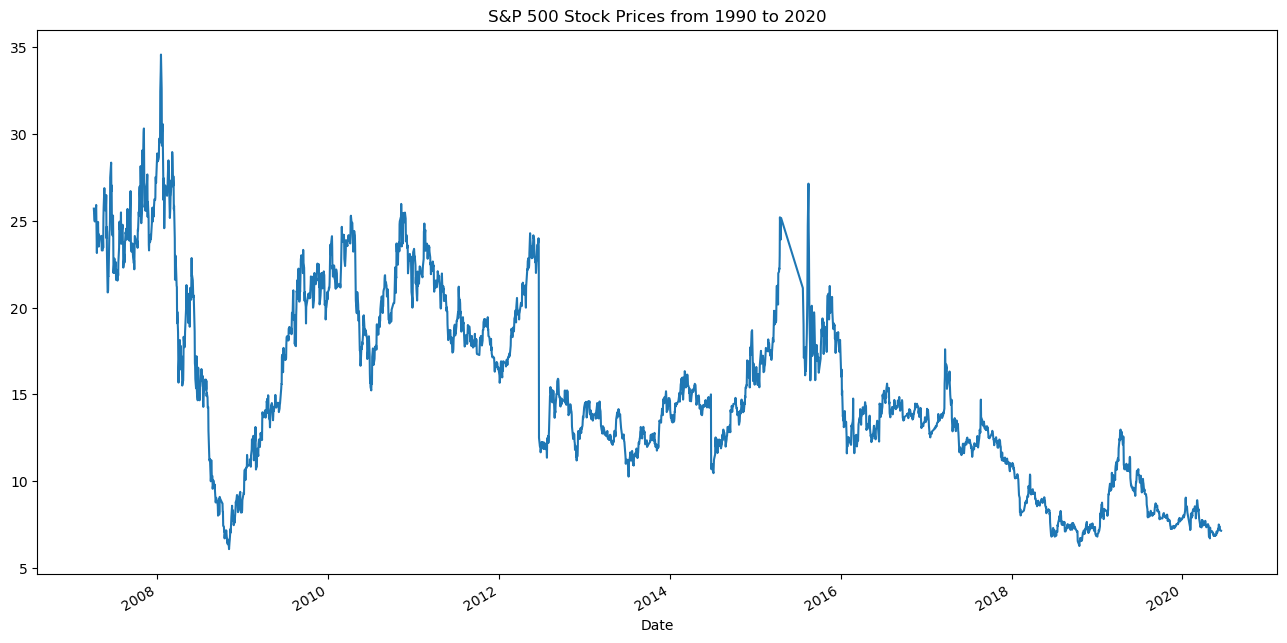

In [142]:
df['Close'].plot(label = 'S&P 500', figsize =(16,8), title = 'S&P 500 Stock Prices from 1990 to 2020')
plt.show()

### Plotting out the 10-days forward looking volatility of  S&P 500 Prices from 1990 to 2020

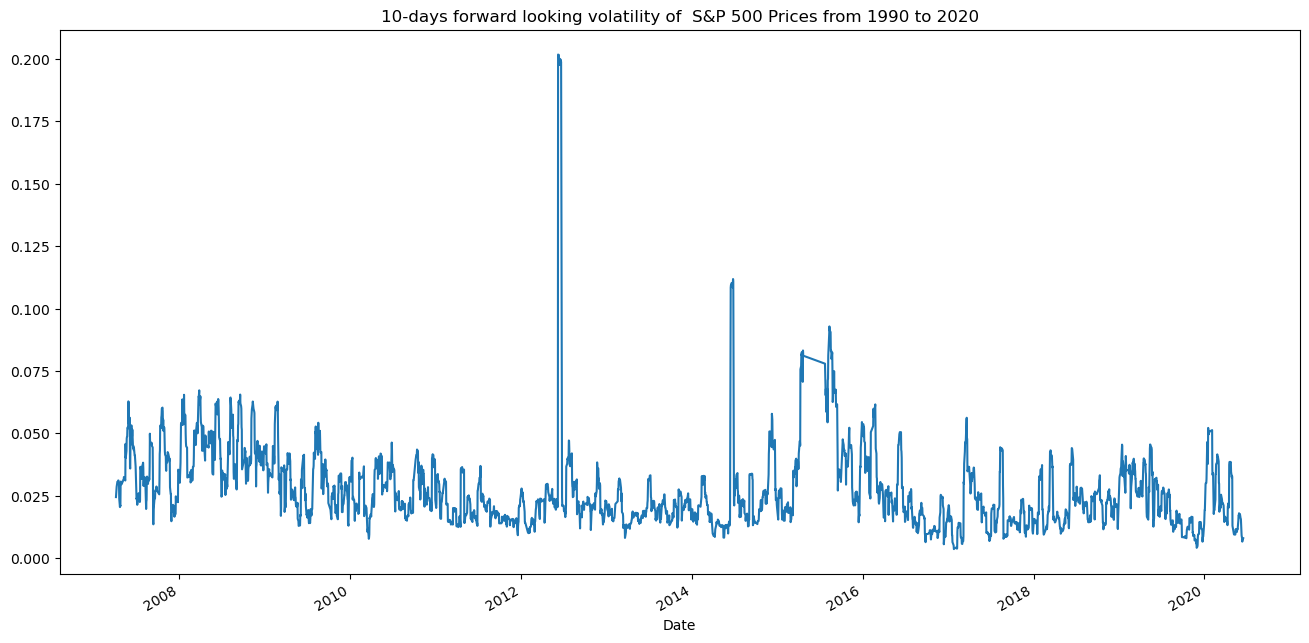

In [144]:
df['Next_10_Days_Volatility'].plot(label = 'S&P 500', figsize =(16,8), title = '10-days forward looking volatility of  S&P 500 Prices from 1990 to 2020')
plt.show()

# Feature Selection

### Pearson Correlation Matrix

In [147]:
def build_pearson_correlation_matrix_of_dataframe(size_x,size_y,dataframe,correlation_target,correlation_minimum_criteria):

    # Using Pearson Correlation

    plt.figure(figsize=(size_x,size_y))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.savefig('Images/pearson_correlation_matrix.png', bbox_inches='tight')
    plt.show()

    # Correlation with output variable

    target = abs(cor[correlation_target])

    #Selecting and printing highly correlated features

    relevant_features = target[target>correlation_minimum_criteria]
    print(relevant_features)

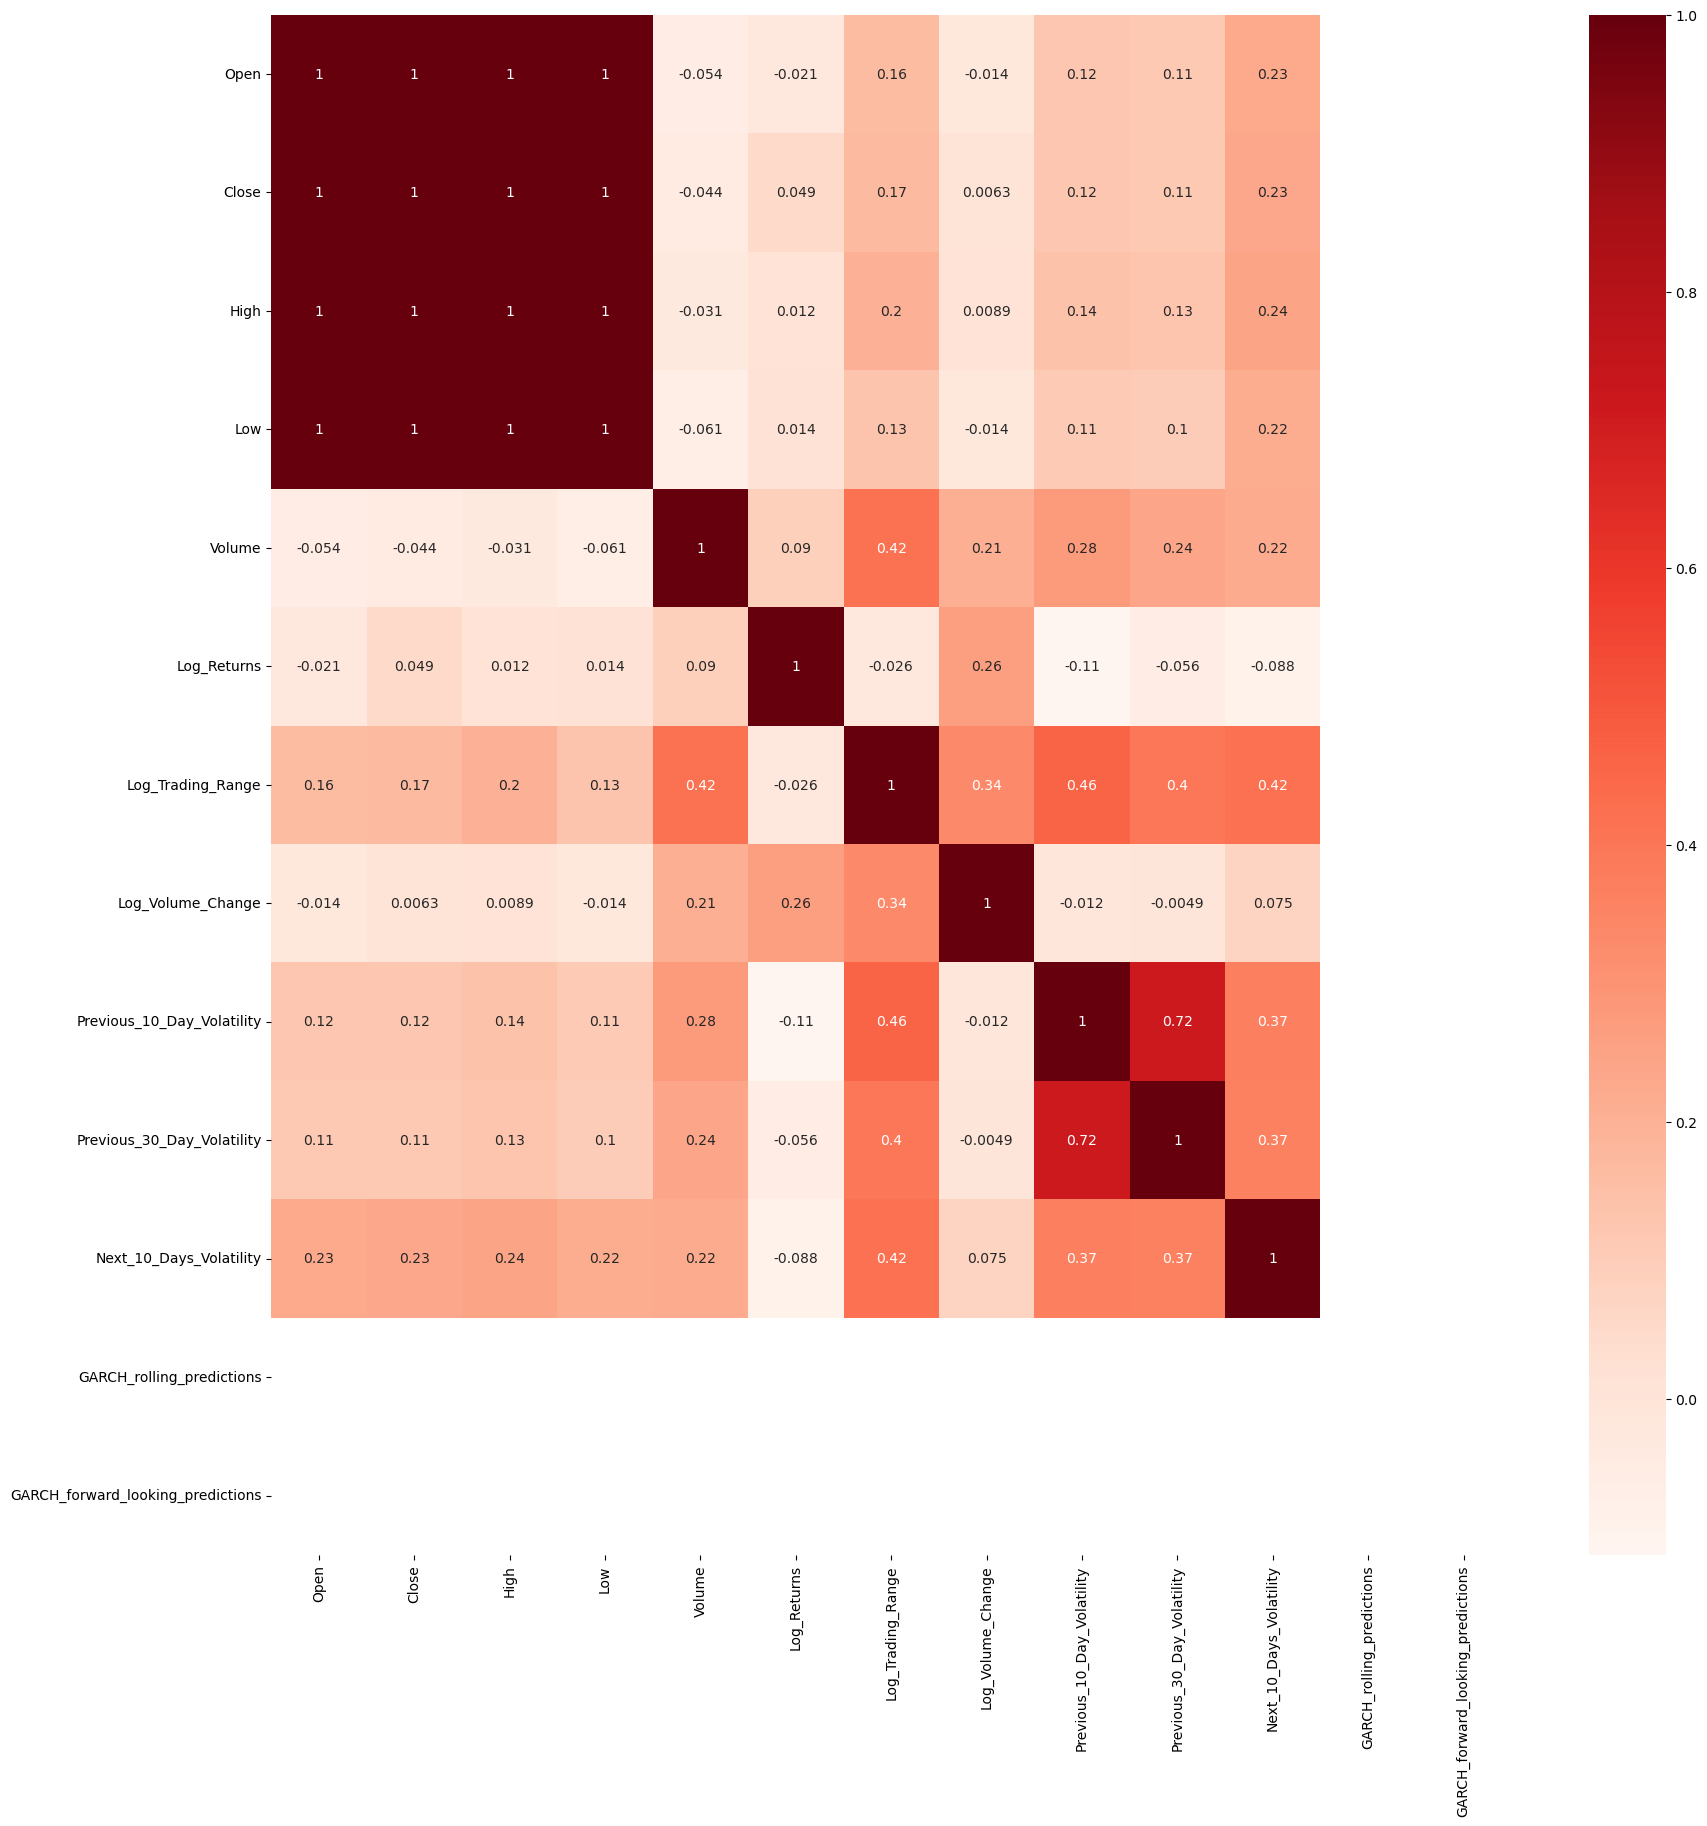

Open                          0.229511
Close                         0.230670
High                          0.244316
Low                           0.217469
Volume                        0.217738
Log_Trading_Range             0.419640
Previous_10_Day_Volatility    0.367808
Previous_30_Day_Volatility    0.365052
Next_10_Days_Volatility       1.000000
Name: Next_10_Days_Volatility, dtype: float64


In [148]:
build_pearson_correlation_matrix_of_dataframe(20,20,df,"Next_10_Days_Volatility",0.2)

# Data Preparation

### Splitting the data into train and test sets

In [ ]:
X = np.array(df.drop(["Next_10_Days_Volatility",'Low','High','Close','Open','Volume','  ], axis=1).values)
y = np.array(df["Next_10_Days_Volatility"].values).reshape(-1, 1) 

test_size = 1500

X_train = X[test_size:,]
X_test = X[:test_size,]
y_train = y[test_size:]
y_test = y[:test_size]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

KeyError: "['MACD_h', 'MACD_sl', 'RSI14', 'SMA14', 'EMA14'] not found in axis"

### Defining a function to get lagged versions of the features

This function increases the number of features of the dataset by "lagging" every feature.

In [ ]:
def get_lagged(x, y, t, s):
    
    lagged = []
    
    for i in range(x.shape[0] - t):
        
        if i == x.shape[0] - t:
            
            break
            
        for k in range(t):
            
            if k < t:
                
                lagged.append(x[i+k])
                
    lagged = np.array(lagged).reshape(s)
    
    return lagged, y[:lagged.shape[0],]

In [ ]:
N = 30

X_train, y_train = get_lagged(X_train, y_train, N, (X_train.shape[0]-N, N*X_train.shape[1]))
X_test, y_test = get_lagged(X_test, y_test, N, (X_test.shape[0]-N, N*X_test.shape[1]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
T = 4

X_train, y_train = get_lagged(X_train, y_train, T, (X_train.shape[0]-T, T, X_train.shape[1]))
X_test, y_test = get_lagged(X_test, y_test, T, (X_test.shape[0]-T, T, X_test.shape[1]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# LSTM

### Building the LSTM Model

In [ ]:
inputLSTM = Input(shape=(X_train.shape[1], X_train.shape[2]))
y = LSTM(200, return_sequences=True)(inputLSTM)
y = LSTM(200)(y)
y = Dense(1)(y)
lstm = Model(inputs=inputLSTM, outputs=y)
lstm.summary()

### Plotting out the LSTM network

In [ ]:
plot_model(lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Declaring the parameters of the LSTM Model

In [ ]:
lstm.compile(optimizer=keras.optimizers.Adam(lr=0.01),loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])

Get data for SPX where you have Open Close and Volumen (1960)

### Fitting the LSTM Model

In [ ]:
hist = lstm.fit(X_train, y_train,batch_size=700,epochs=60,verbose=1,validation_split=0.3,shuffle=False)

### Plotting the RSME for training and validation

In [ ]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Printing out the predictions made by the model

In [ ]:
for ind, i in enumerate(lstm.predict(X_test)):
    
    print('Prediction: ' + str('{:.2f}'.format(round(100 * round(i[0], 4),3))) + ',    ' + 'Actual Value: ' + str('{:.2f}'.format(round(100 * round(y_test[ind][0],4),2))))

### Printing out the results of the model

In [ ]:
def printing_out_results_of_a_model(model,X_test,y_test):
    
    y_pred = model.predict(X_test)
    
    # Print the R2 score 

    print ("R2 score:\n") 
    print (('{:.2f}'.format((100*(r2_score(y_test, y_pred))))) + " %")

    print ("\n")
    
    # Print the RMSE

    print ("RMSE:\n")
    print (math.sqrt(mean_squared_error(y_test, y_pred)))
    
    print ('\n')
    
    # Print the mean squared error
    
    print ("Mean Squared Error:\n")
    print (mean_squared_error(y_test, y_pred))

In [ ]:
printing_out_results_of_a_model(lstm, X_test, y_test)